# SFC PAYGo Solar Credit Repayment Competition

<br>

In [1002]:
import pandas as pd
import missingno as msno
import seaborn as sns
import numpy as np
import ast
from fancyimpute import IterativeImputer
from dateutil.relativedelta import *
from sklearn.preprocessing import LabelEncoder

In [1003]:
train = pd.read_csv("Train.csv")

In [1004]:
train.head()

,ID,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6
0,ID_MR53LEX,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",880.0,930.0,495.0,715.0,220.0,385.0
1,ID_3D7NQUH,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",660.0,935.0,935.0,825.0,770.0,935.0
2,ID_0IWQNPI,"['02-2020', '03-2020', '04-2020', '05-2020', '...","[2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]",700.0,1350.0,1550.0,1400.0,1450.0,1200.0
3,ID_IY8SYB9,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...",580.0,480.0,800.0,1260.0,1650.0,530.0
4,ID_9XHL7VZ,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...",40.0,440.0,460.0,360.0,80.0,330.0


In [1005]:
train.dtypes

ID                   object
TransactionDates     object
PaymentsHistory      object
m1                  float64
m2                  float64
m3                  float64
m4                  float64
m5                  float64
m6                  float64
dtype: object

In [1006]:
train.shape

(28007, 9)

In [1007]:
train.describe()

,m1,m2,m3,m4,m5,m6
count,28007.000000,28007.000000,28007.000000,28007.000000,28007.000000,28007.000000
mean,815.411683,807.101617,797.641161,815.011033,827.719463,692.115150
std,686.130805,839.772177,696.809281,715.582046,796.379837,1416.301221
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,275.000000,250.000000,220.000000,230.000000,220.000000,130.000000
50%,820.000000,800.000000,790.000000,815.000000,840.000000,480.000000
75%,1200.000000,1200.000000,1200.000000,1200.000000,1205.000000,915.000000
max,33890.000000,94044.000000,32005.000000,33403.000000,64106.000000,96814.000000


In [1008]:
train['FirstTransactionDate'] = np.nan

In [1009]:
train['LastTransactionDate'] = np.nan

In [1010]:
train["TotalPastPayments"] = np.nan

In [1011]:
train["NumPayments"] = np.nan

In [1012]:
sum_payments = 0.0

for i,data in train.iterrows():
    transaction_dates = []
    payments = []
    dates = data.iloc[1][1:-1].split(", ")
    paymentshistory = data.iloc[2][1:-1].split(", ")
    for date in dates:
        transaction_dates.append(pd.to_datetime(date[1:-1]).date())
    train.TransactionDates.iloc[i] = np.array(transaction_dates)
    train.LastTransactionDate.iloc[i] = transaction_dates[-1]
    train.FirstTransactionDate.iloc[i] = transaction_dates[0]
    
    for payment in paymentshistory:
        payments.append(float(payment))
    train.PaymentsHistory.iloc[i] = np.array(payments)
    train.NumPayments.iloc[i] = len(payments)
    
    
    train.TotalPastPayments.iloc[i] = sum(payments)
train.head()

/Users/devanshimittal/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,ID,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6,FirstTransactionDate,LastTransactionDate,TotalPastPayments,NumPayments
0,ID_MR53LEX,"[2018-04-01, 2018-05-01, 2018-06-01, 2018-07-0...","[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",880.0,930.0,495.0,715.0,220.0,385.0,2018-04-01,2020-11-01,16035.0,31.0
1,ID_3D7NQUH,"[2018-04-01, 2018-05-01, 2018-06-01, 2018-07-0...","[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",660.0,935.0,935.0,825.0,770.0,935.0,2018-04-01,2020-11-01,22136.0,30.0
2,ID_0IWQNPI,"[2020-02-01, 2020-03-01, 2020-04-01, 2020-05-0...","[2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]",700.0,1350.0,1550.0,1400.0,1450.0,1200.0,2020-02-01,2020-07-01,6760.0,6.0
3,ID_IY8SYB9,"[2017-09-01, 2017-10-01, 2017-11-01, 2017-12-0...","[2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...",580.0,480.0,800.0,1260.0,1650.0,530.0,2017-09-01,2018-06-01,11260.0,10.0
4,ID_9XHL7VZ,"[2017-09-01, 2017-10-01, 2017-11-01, 2017-12-0...","[2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...",40.0,440.0,460.0,360.0,80.0,330.0,2017-09-01,2019-11-01,7779.0,22.0


In [1013]:
date_list = []
for i,data in train.iterrows():
    dates = data[1]
    for date in dates:
        if not date in date_list:
            date_list.append(date)
date_list.sort()

            

In [1014]:
for col in date_list:
    train[col] = np.nan
train.head()

,ID,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6,FirstTransactionDate,...,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01
0,ID_MR53LEX,"[2018-04-01, 2018-05-01, 2018-06-01, 2018-07-0...","[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",880.0,930.0,495.0,715.0,220.0,385.0,2018-04-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ID_3D7NQUH,"[2018-04-01, 2018-05-01, 2018-06-01, 2018-07-0...","[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",660.0,935.0,935.0,825.0,770.0,935.0,2018-04-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ID_0IWQNPI,"[2020-02-01, 2020-03-01, 2020-04-01, 2020-05-0...","[2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]",700.0,1350.0,1550.0,1400.0,1450.0,1200.0,2020-02-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ID_IY8SYB9,"[2017-09-01, 2017-10-01, 2017-11-01, 2017-12-0...","[2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...",580.0,480.0,800.0,1260.0,1650.0,530.0,2017-09-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ID_9XHL7VZ,"[2017-09-01, 2017-10-01, 2017-11-01, 2017-12-0...","[2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...",40.0,440.0,460.0,360.0,80.0,330.0,2017-09-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1015]:
for i, data in train.iterrows():
    for j in range(len(data[2])):
        train[data[1][j]][i] = data[2][j]

<ipython-input-1015-cebc60107db1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[data[1][j]][i] = data[2][j]


In [1016]:
for i, data in train.iterrows():
    first = data[9]
    last = data[10]
    while first != last:
        first += relativedelta(months=+1)
        if train.loc[i,first]== float("nan"):
            train.loc[i,first] = 0.0
            
            
            
        

In [1017]:
train.drop(columns=["TransactionDates", "PaymentsHistory"], inplace = True)
train.head()

,ID,m1,m2,m3,m4,m5,m6,FirstTransactionDate,LastTransactionDate,TotalPastPayments,...,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01
0,ID_MR53LEX,880.0,930.0,495.0,715.0,220.0,385.0,2018-04-01,2020-11-01,16035.0,...,120.0,260.0,610.0,230.0,390.0,660.0,1200.0,1320.0,280.0,770.0
1,ID_3D7NQUH,660.0,935.0,935.0,825.0,770.0,935.0,2018-04-01,2020-11-01,22136.0,...,655.0,605.0,495.0,442.0,495.0,605.0,660.0,660.0,655.0,770.0
2,ID_0IWQNPI,700.0,1350.0,1550.0,1400.0,1450.0,1200.0,2020-02-01,2020-07-01,6760.0,...,2850.0,1500.0,1350.0,610.0,200.0,250.0,NaN,NaN,NaN,NaN
3,ID_IY8SYB9,580.0,480.0,800.0,1260.0,1650.0,530.0,2017-09-01,2018-06-01,11260.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ID_9XHL7VZ,40.0,440.0,460.0,360.0,80.0,330.0,2017-09-01,2019-11-01,7779.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1018]:
train.columns = train.columns.astype(str)

In [1019]:
train.fillna(0, inplace=True)

In [1020]:
train.head()

,ID,m1,m2,m3,m4,m5,m6,FirstTransactionDate,LastTransactionDate,TotalPastPayments,...,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01
0,ID_MR53LEX,880.0,930.0,495.0,715.0,220.0,385.0,2018-04-01,2020-11-01,16035.0,...,120.0,260.0,610.0,230.0,390.0,660.0,1200.0,1320.0,280.0,770.0
1,ID_3D7NQUH,660.0,935.0,935.0,825.0,770.0,935.0,2018-04-01,2020-11-01,22136.0,...,655.0,605.0,495.0,442.0,495.0,605.0,660.0,660.0,655.0,770.0
2,ID_0IWQNPI,700.0,1350.0,1550.0,1400.0,1450.0,1200.0,2020-02-01,2020-07-01,6760.0,...,2850.0,1500.0,1350.0,610.0,200.0,250.0,0.0,0.0,0.0,0.0
3,ID_IY8SYB9,580.0,480.0,800.0,1260.0,1650.0,530.0,2017-09-01,2018-06-01,11260.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ID_9XHL7VZ,40.0,440.0,460.0,360.0,80.0,330.0,2017-09-01,2019-11-01,7779.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


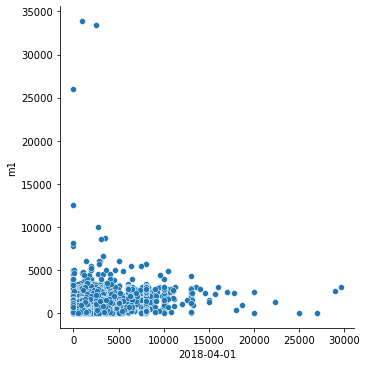

In [1021]:
sns.relplot(x="2018-04-01",y="m1",data=train,kind="scatter")

In [1022]:
train.describe()

,m1,m2,m3,m4,m5,m6,TotalPastPayments,NumPayments,2015-11-01,2015-12-01,...,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01
count,28007.000000,28007.000000,28007.000000,28007.000000,28007.000000,28007.000000,28007.000000,28007.000000,28007.000000,28007.000000,...,28007.000000,28007.000000,28007.000000,28007.000000,28007.000000,28007.000000,28007.000000,28007.000000,28007.000000,28007.000000
mean,815.411683,807.101617,797.641161,815.011033,827.719463,692.115150,15076.502624,16.262363,0.722141,6.849716,...,499.773200,338.879316,294.982004,286.568215,227.774806,198.694362,151.029921,114.242261,92.591067,68.795230
std,686.130805,839.772177,696.809281,715.582046,796.379837,1416.301221,8564.361449,9.248264,40.714982,163.963949,...,901.221569,497.098470,455.228920,493.424879,422.159020,416.402485,332.602527,322.262146,295.654127,223.000587
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2220.000000,5.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,275.000000,250.000000,220.000000,230.000000,220.000000,130.000000,8900.000000,8.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,820.000000,800.000000,790.000000,815.000000,840.000000,480.000000,11650.000000,14.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1200.000000,1200.000000,1200.000000,1200.000000,1205.000000,915.000000,23600.000000,23.000000,0.000000,0.000000,...,720.000000,665.000000,550.000000,495.000000,300.000000,200.000000,60.000000,0.000000,0.000000,0.000000
max,33890.000000,94044.000000,32005.000000,33403.000000,64106.000000,96814.000000,95189.000000,52.000000,3000.000000,13300.000000,...,7000.000000,10315.000000,5230.000000,31590.000000,19165.000000,25428.000000,3275.000000,24070.000000,24350.000000,2870.000000


In [1023]:
def print_boxplot(attr):
    sns.boxplot(x=train[attr])
    


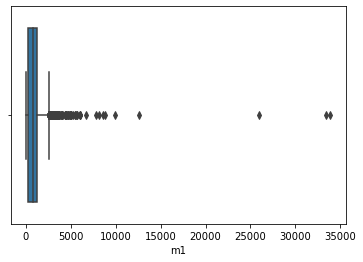

In [1024]:
print_boxplot("m1")

In [1025]:
train = train.loc[train.m1<=10000,:]

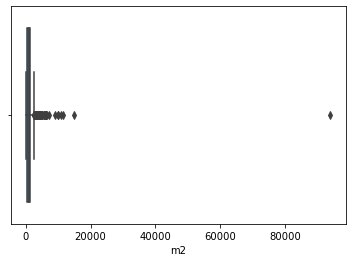

In [1026]:
print_boxplot("m2")

In [1027]:
train = train.loc[train.m2<=6000,:]

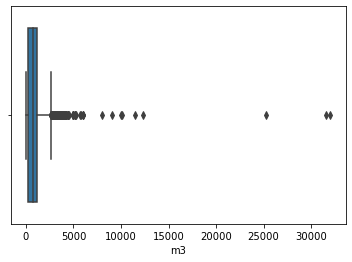

In [1028]:
print_boxplot("m3")

In [1029]:
train = train.loc[train.m3<=15000,:]

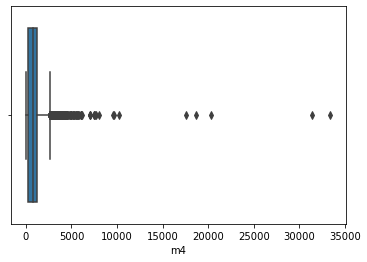

In [1030]:
print_boxplot("m4")

In [1031]:
train = train.loc[train.m4<=10000,:]

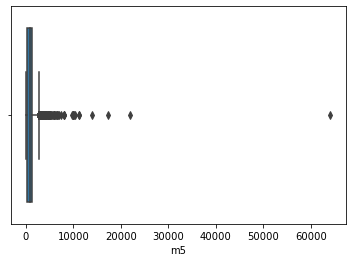

In [1032]:
print_boxplot("m5")

In [1033]:
train = train.loc[train.m5<=10000,:]

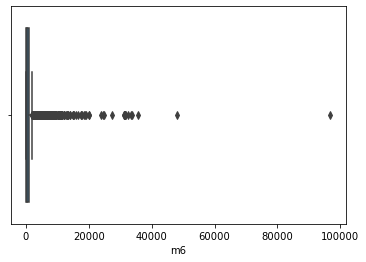

In [1034]:
print_boxplot("m6")

In [1035]:
train = train.loc[train.m6<=40000,:]

In [1036]:
test = pd.read_csv("Test.csv")

In [1037]:
test.head()

,ID,TransactionDates,PaymentsHistory
0,ID_6L67PAA,"['12-2015', '01-2016', '02-2016', '03-2016', '...","[4000.0, 1050.0, 1050.0, 1050.0, 1050.0, 400.0]"
1,ID_VJ80SX2,"['12-2015', '01-2016', '02-2016', '03-2016', '...","[3000.0, 850.0, 750.0, 1500.0, 650.0, 1250.0, ..."
2,ID_7OU9HLK,"['12-2015', '01-2016', '03-2016', '05-2016', '...","[2400.0, 300.0, 500.0, 450.0, 675.0, 700.0, 87..."
3,ID_WVWTPGK,"['12-2015', '01-2016', '02-2016', '03-2016', '...","[4700.0, 1200.0, 950.0, 1200.0, 900.0, 1110.0,..."
4,ID_04DSDQS,"['12-2015', '01-2016', '02-2016', '03-2016', '...","[4800.0, 750.0, 995.0, 995.0, 1300.0, 750.0, 1..."


In [1038]:
test.dtypes

ID                  object
TransactionDates    object
PaymentsHistory     object
dtype: object

In [1039]:
test.shape

(9336, 3)

In [1040]:
test.nunique()

ID                  9336
TransactionDates    2938
PaymentsHistory     9290
dtype: int64

In [1041]:
test.isnull().sum()

ID                  0
TransactionDates    0
PaymentsHistory     0
dtype: int64

In [1042]:
test['FirstTransactionDate'] = np.nan

In [1043]:
test['LastTransactionDate'] = np.nan

In [1044]:
test["TotalPastPayments"] = np.nan

In [1045]:
test["NumPayments"] = np.nan

In [1046]:
sum_payments = 0.0

for i,data in test.iterrows():
    transaction_dates = []
    payments = []
    dates = data.iloc[1][1:-1].split(", ")
    paymentshistory = data.iloc[2][1:-1].split(", ")
    for date in dates:
        transaction_dates.append(pd.to_datetime(date[1:-1]).date())
    test.TransactionDates.iloc[i] = np.array(transaction_dates)
    test.LastTransactionDate.iloc[i] = transaction_dates[-1]
    test.FirstTransactionDate.iloc[i] = transaction_dates[0]
    
    for payment in paymentshistory:
        payments.append(float(payment))
    test.PaymentsHistory.iloc[i] = np.array(payments)
    test.NumPayments.iloc[i] = len(payments)
   
    
    
    test.TotalPastPayments.iloc[i] = sum(payments)


/Users/devanshimittal/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [1047]:
date_list_test = []
for i,data in test.iterrows():
    dates = data[1]
    for date in dates:
        if not date in date_list_test:
            date_list_test.append(date)
date_list_test.sort()


In [1048]:
for col in date_list_test:
    test[col] = np.nan


In [1049]:
for i, data in test.iterrows():
    for j in range(len(data[2])):
        test[data[1][j]][i] = data[2][j]

<ipython-input-1049-33bed966026e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[data[1][j]][i] = data[2][j]


In [1050]:
test.drop(columns=["TransactionDates", "PaymentsHistory"], inplace = True)


In [1051]:
test.columns = test.columns.astype(str)

In [1052]:
test.fillna(0, inplace=True)

In [1053]:
test.head()

,ID,FirstTransactionDate,LastTransactionDate,TotalPastPayments,NumPayments,2015-11-01,2015-12-01,2016-01-01,2016-02-01,2016-03-01,...,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01
0,ID_6L67PAA,2015-12-01,2016-07-01,8600.0,6.0,0.0,4000.0,1050.0,1050.0,1050.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ID_VJ80SX2,2015-12-01,2016-06-01,9000.0,7.0,0.0,3000.0,850.0,750.0,1500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ID_7OU9HLK,2015-12-01,2017-02-01,6075.0,8.0,0.0,2400.0,300.0,0.0,500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ID_WVWTPGK,2015-12-01,2016-11-01,15195.0,12.0,0.0,4700.0,1200.0,950.0,1200.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ID_04DSDQS,2015-12-01,2016-08-01,11590.0,9.0,0.0,4800.0,750.0,995.0,995.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1054]:
metadata = pd.read_csv("metadata.csv")

/Users/devanshimittal/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [1055]:
metadata.head()

,ID,RegistrationDate,Deposit,UpsellDate,AccessoryRate,PaymentMethod,rateTypeEntity,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Region,Town,Occupation,SupplierName,Term,TotalContractValue,ExpectedTermDate,FirstPaymentDate,LastPaymentDate
0,ID_K00S4N4,2015-12-10 00:00:00,2000,NaN,0.0,FINANCED,DAILY,35,7,Male,41.0,Mount Kenya Region,Embu,Other,d_light,364,14740.0,2016-12-08 00:00:00,2015-12-10 09:52:35,2016-10-23 04:52:30
1,ID_6L67PAA,2015-12-09 00:00:00,2000,NaN,0.0,FINANCED,DAILY,35,7,Male,33.0,Coast Region,Kilifi,Other,d_light,364,14740.0,2016-12-07 00:00:00,2015-12-09 13:14:03,2020-05-24 15:32:18
2,ID_102CV85,2015-12-18 00:00:00,2000,2018-03-29 10:14:58,35.0,FINANCED,DAILY,35,7,Female,48.0,Nairobi Region,Makueni,Business,d_light,392,29480.0,2017-01-13 00:00:00,2015-12-18 06:22:34,2017-02-01 15:23:44
3,ID_HXBJFHB,2015-11-25 00:00:00,2000,NaN,0.0,FINANCED,DAILY,35,7,Female,43.0,NaN,UNKNOWN,Teacher,d_light,364,14740.0,2016-11-23 00:00:00,2015-11-25 13:25:57,2017-05-22 16:46:54
4,ID_3K9VZ5J,2015-12-02 00:00:00,2000,NaN,0.0,FINANCED,DAILY,35,7,Female,56.0,Mount Kenya Region,Kirinyaga,Other,d_light,364,14740.0,2016-11-30 00:00:00,2015-12-05 10:34:32,2017-05-12 16:50:52


In [1056]:
metadata.dtypes

ID                      object
RegistrationDate        object
Deposit                  int64
UpsellDate              object
AccessoryRate          float64
PaymentMethod           object
rateTypeEntity          object
RatePerUnit              int64
DaysOnDeposit            int64
MainApplicantGender     object
Age                    float64
Region                  object
Town                    object
Occupation              object
SupplierName            object
Term                     int64
TotalContractValue     float64
ExpectedTermDate        object
FirstPaymentDate        object
LastPaymentDate         object
dtype: object

In [1057]:
metadata.shape

(37343, 20)

In [1058]:
metadata.columns

Index(['ID', 'RegistrationDate', 'Deposit', 'UpsellDate', 'AccessoryRate',
       'PaymentMethod', 'rateTypeEntity', 'RatePerUnit', 'DaysOnDeposit',
       'MainApplicantGender', 'Age', 'Region', 'Town', 'Occupation',
       'SupplierName', 'Term', 'TotalContractValue', 'ExpectedTermDate',
       'FirstPaymentDate', 'LastPaymentDate'],
      dtype='object')

In [1059]:
metadata.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
37338    False
37339    False
37340    False
37341    False
37342    False
Length: 37343, dtype: bool

In [1060]:
metadata.RegistrationDate = pd.to_datetime(metadata.RegistrationDate, format="%Y/%m/%d %H:%M:%S")
metadata.RegistrationDate

0       2015-12-10 00:00:00
1       2015-12-09 00:00:00
2       2015-12-18 00:00:00
3       2015-11-25 00:00:00
4       2015-12-02 00:00:00
                ...        
37338   2020-02-20 18:26:52
37339   2020-02-20 18:30:59
37340   2020-02-20 18:42:26
37341   2020-02-20 18:46:30
37342   2020-02-20 19:30:43
Name: RegistrationDate, Length: 37343, dtype: datetime64[ns]

In [1061]:
metadata.ExpectedTermDate = pd.to_datetime(metadata.ExpectedTermDate, format="%Y/%m/%d %H:%M:%S")
metadata.FirstPaymentDate = pd.to_datetime(metadata.FirstPaymentDate, format="%Y/%m/%d %H:%M:%S")
metadata.LastPaymentDate = pd.to_datetime(metadata.LastPaymentDate, format="%Y/%m/%d %H:%M:%S")
metadata.UpsellDate = pd.to_datetime(metadata.UpsellDate, format="%Y/%m/%d %H:%M:%S")

In [1062]:
metadata.dtypes

ID                             object
RegistrationDate       datetime64[ns]
Deposit                         int64
UpsellDate             datetime64[ns]
AccessoryRate                 float64
PaymentMethod                  object
rateTypeEntity                 object
RatePerUnit                     int64
DaysOnDeposit                   int64
MainApplicantGender            object
Age                           float64
Region                         object
Town                           object
Occupation                     object
SupplierName                   object
Term                            int64
TotalContractValue            float64
ExpectedTermDate       datetime64[ns]
FirstPaymentDate       datetime64[ns]
LastPaymentDate        datetime64[ns]
dtype: object

In [1063]:
metadata.isnull().sum()

ID                         0
RegistrationDate           0
Deposit                    0
UpsellDate             36370
AccessoryRate              0
PaymentMethod              0
rateTypeEntity             0
RatePerUnit                0
DaysOnDeposit              0
MainApplicantGender        0
Age                     6939
Region                  1934
Town                       0
Occupation                 0
SupplierName               0
Term                       0
TotalContractValue         0
ExpectedTermDate           0
FirstPaymentDate           0
LastPaymentDate            0
dtype: int64

In [1064]:
metadata.isnull().sum()/metadata.shape[0]*100

ID                      0.000000
RegistrationDate        0.000000
Deposit                 0.000000
UpsellDate             97.394425
AccessoryRate           0.000000
PaymentMethod           0.000000
rateTypeEntity          0.000000
RatePerUnit             0.000000
DaysOnDeposit           0.000000
MainApplicantGender     0.000000
Age                    18.581796
Region                  5.179016
Town                    0.000000
Occupation              0.000000
SupplierName            0.000000
Term                    0.000000
TotalContractValue      0.000000
ExpectedTermDate        0.000000
FirstPaymentDate        0.000000
LastPaymentDate         0.000000
dtype: float64

<AxesSubplot:>

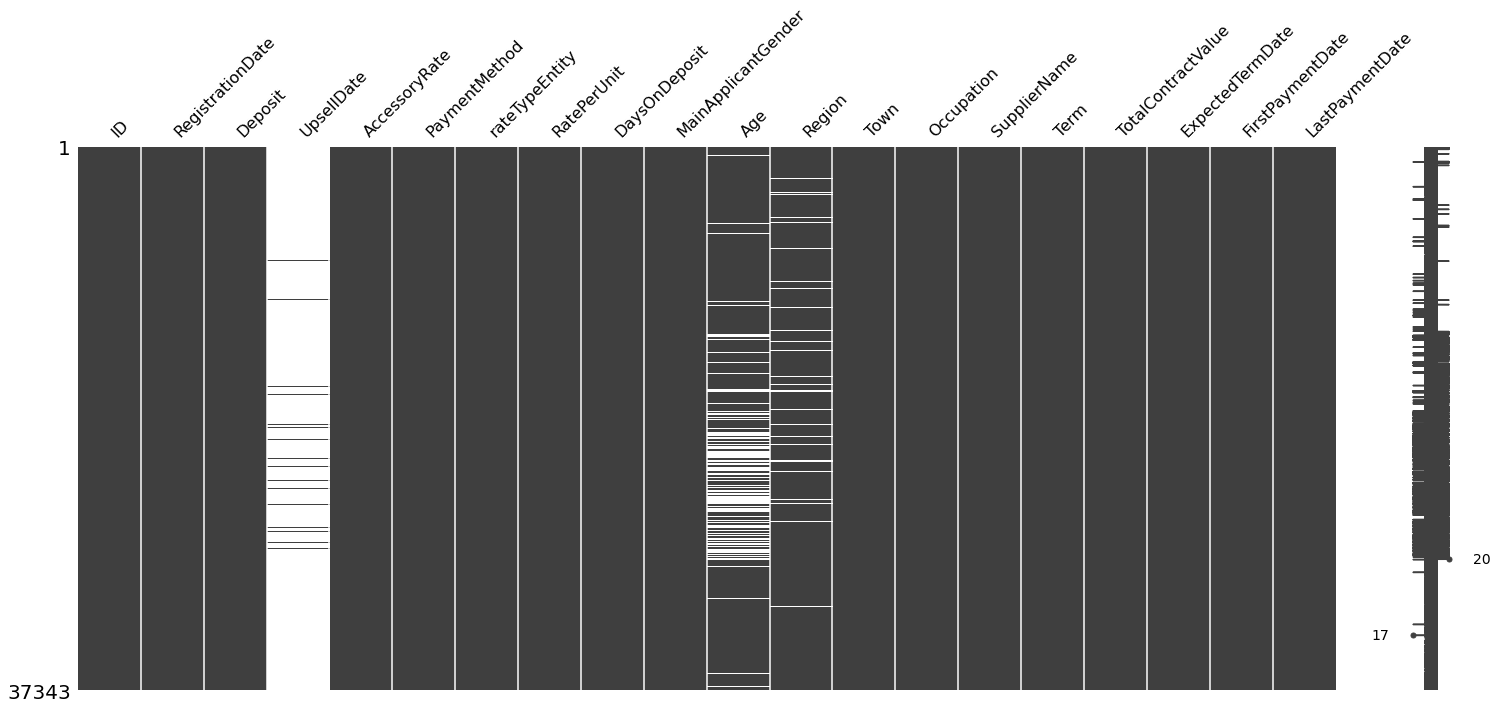

In [1065]:
msno.matrix(metadata)

Dropping UpsellDate because of too many missing values

In [1066]:
metadata.drop(columns = "UpsellDate", inplace = True)

In [1067]:
metadata.Region.unique()

array(['Mount Kenya Region', 'Coast Region', 'Nairobi Region', nan,
       'South Rift', 'Western', 'North Rift', 'Nyanza'], dtype=object)

In [1068]:
metadata.describe()

,Deposit,AccessoryRate,RatePerUnit,DaysOnDeposit,Age,Term,TotalContractValue
count,37343.000000,37343.000000,37343.000000,37343.000000,30404.000000,37343.000000,37343.000000
mean,2348.631685,1.136090,49.923868,4.600835,38.855677,412.427657,22953.005142
std,417.814614,7.791789,57.500215,3.429060,12.300827,121.602544,10149.863172
min,0.000000,0.000000,35.000000,0.000000,19.000000,10.000000,10800.000000
25%,2000.000000,0.000000,40.000000,3.000000,29.000000,364.000000,16560.000000
50%,2000.000000,0.000000,40.000000,3.000000,36.000000,364.000000,16560.000000
75%,2500.000000,0.000000,55.000000,7.000000,46.000000,547.000000,33080.000000
max,8000.000000,240.000000,4000.000000,60.000000,120.000000,626.000000,64484.000000


<AxesSubplot:>

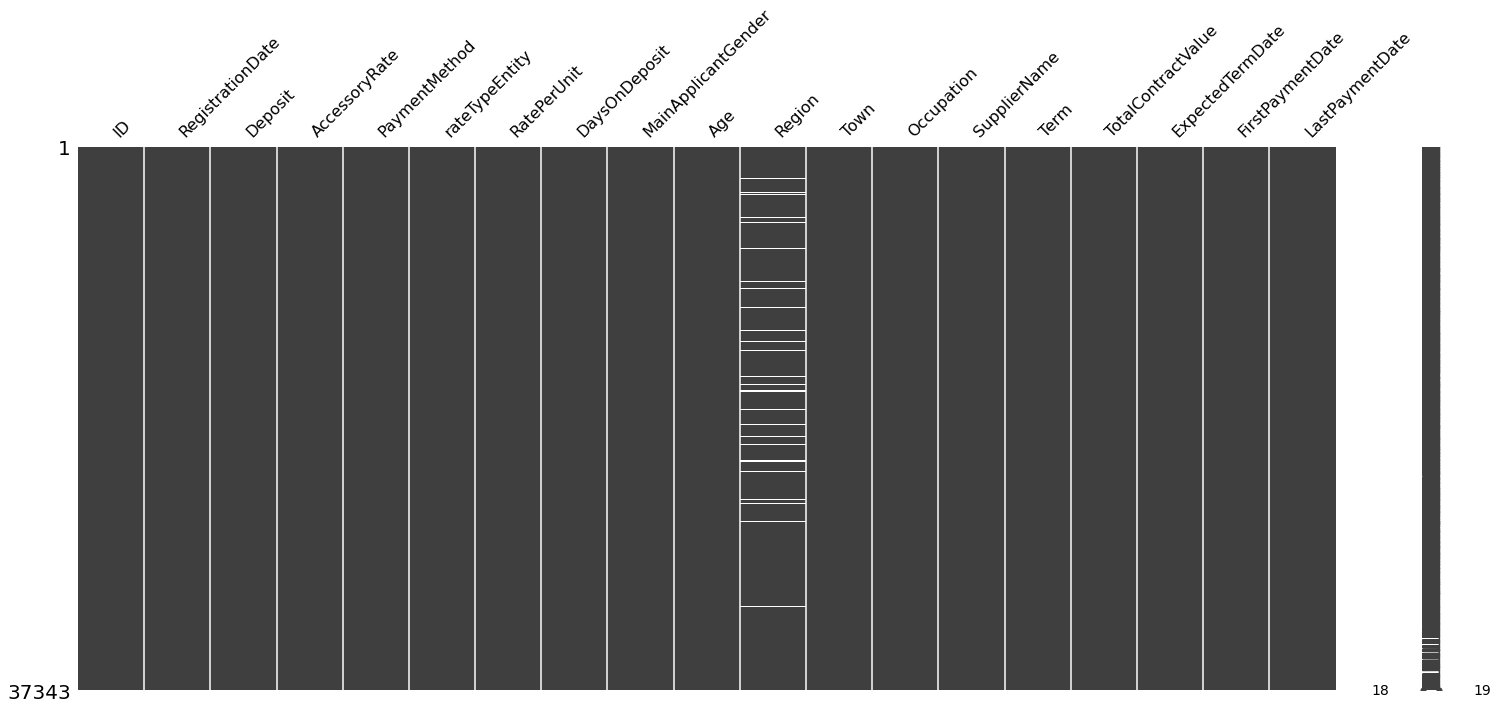

In [1069]:
impute = metadata[['Deposit', 'AccessoryRate', 'RatePerUnit', 'DaysOnDeposit', 
                   'Term', 'TotalContractValue', 'Age']]
impute = impute.to_numpy()
impute = IterativeImputer().fit_transform(impute)
metadata.Age = impute[:,-1]
msno.matrix(metadata)

<AxesSubplot:xlabel='Age'>

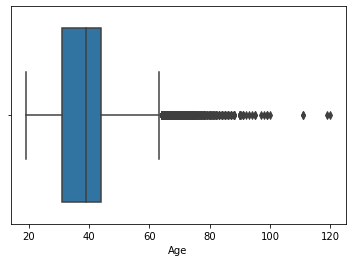

In [1070]:
sns.boxplot(x=metadata.Age)

In [1071]:
metadata.loc[(metadata.Age>100)]

,ID,RegistrationDate,Deposit,AccessoryRate,PaymentMethod,rateTypeEntity,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Region,Town,Occupation,SupplierName,Term,TotalContractValue,ExpectedTermDate,FirstPaymentDate,LastPaymentDate
6134,ID_OCAFVZ1,2017-08-16 14:54:02,2000,0.0,FINANCED,DAILY,40,7,Female,111.0,North Rift,Baringo,Business,d_light,364,16560.0,2018-08-15 14:54:02,2017-08-16 14:53:55,2019-03-21 17:08:18
25499,ID_96DYWMV,2018-04-16 09:33:10,2500,0.0,FINANCED,DAILY,55,3,Male,120.0,Coast Region,Taita/Taveta,Farmer,d_light,556,33080.0,2019-10-24 09:33:10,2018-04-16 09:33:10,2021-01-02 11:28:04
27110,ID_YESNWWD,2018-04-24 16:36:33,2500,0.0,FINANCED,DAILY,55,3,Female,119.0,Nyanza,Kisumu,Business,d_light,556,33080.0,2019-11-01 16:36:33,2018-04-24 16:36:32,2021-05-24 16:15:07
29785,ID_1HID3PG,2020-01-10 12:52:53,2000,0.0,FINANCED,DAILY,40,3,Male,111.0,Coast Region,Kilifi,Business,d_light,270,12800.0,2020-10-06 12:52:53,2020-01-10 12:53:02,2021-02-05 16:11:21


In [1072]:
#metadata = metadata.loc[metadata.Age<=100]

<AxesSubplot:>

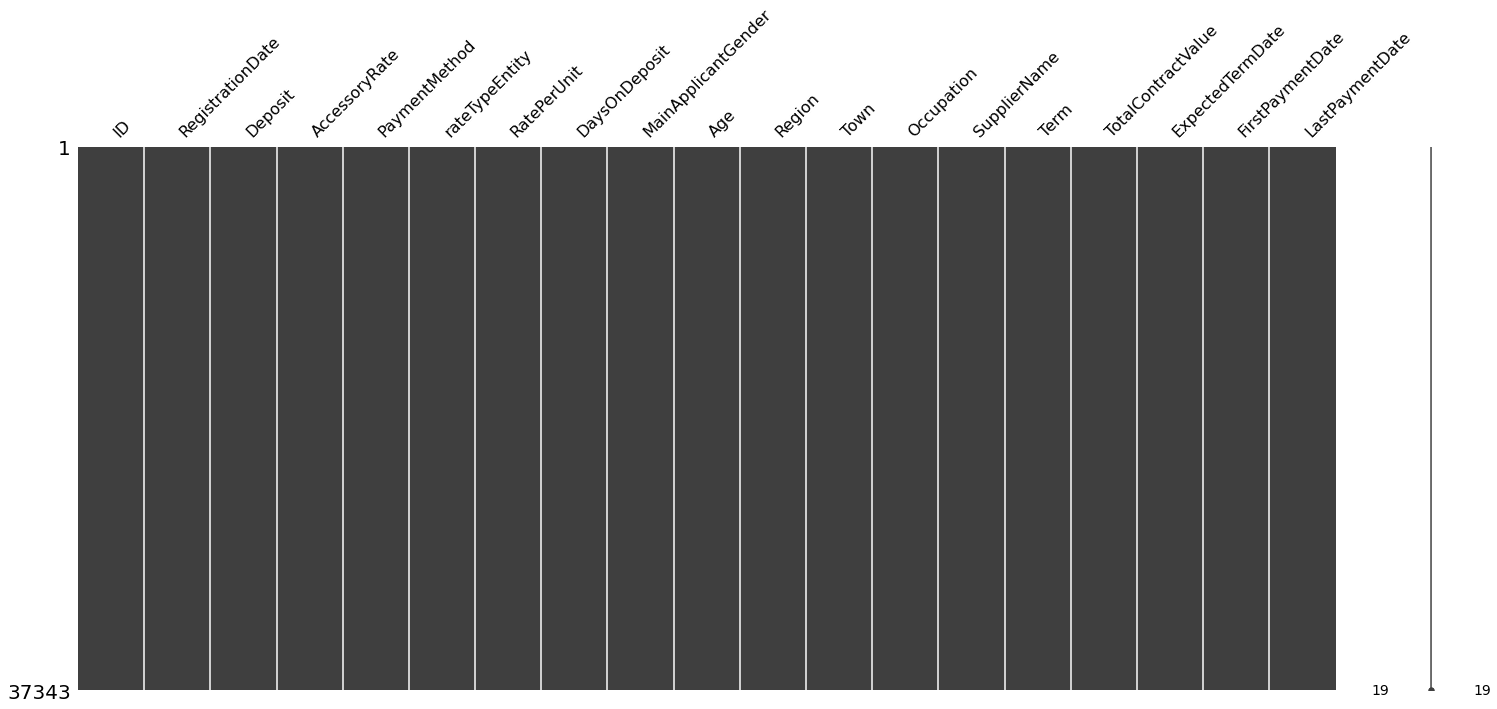

In [1073]:
metadata.Region.fillna(value=metadata.Region.mode()[0], inplace=True)
msno.matrix(metadata)

In [1074]:
metadata.head(10)

,ID,RegistrationDate,Deposit,AccessoryRate,PaymentMethod,rateTypeEntity,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Region,Town,Occupation,SupplierName,Term,TotalContractValue,ExpectedTermDate,FirstPaymentDate,LastPaymentDate
0,ID_K00S4N4,2015-12-10,2000,0.0,FINANCED,DAILY,35,7,Male,41.000000,Mount Kenya Region,Embu,Other,d_light,364,14740.0,2016-12-08,2015-12-10 09:52:35,2016-10-23 04:52:30
1,ID_6L67PAA,2015-12-09,2000,0.0,FINANCED,DAILY,35,7,Male,33.000000,Coast Region,Kilifi,Other,d_light,364,14740.0,2016-12-07,2015-12-09 13:14:03,2020-05-24 15:32:18
2,ID_102CV85,2015-12-18,2000,35.0,FINANCED,DAILY,35,7,Female,48.000000,Nairobi Region,Makueni,Business,d_light,392,29480.0,2017-01-13,2015-12-18 06:22:34,2017-02-01 15:23:44
3,ID_HXBJFHB,2015-11-25,2000,0.0,FINANCED,DAILY,35,7,Female,43.000000,Nyanza,UNKNOWN,Teacher,d_light,364,14740.0,2016-11-23,2015-11-25 13:25:57,2017-05-22 16:46:54
4,ID_3K9VZ5J,2015-12-02,2000,0.0,FINANCED,DAILY,35,7,Female,56.000000,Mount Kenya Region,Kirinyaga,Other,d_light,364,14740.0,2016-11-30,2015-12-05 10:34:32,2017-05-12 16:50:52
5,ID_VJ80SX2,2015-12-14,2000,0.0,FINANCED,DAILY,35,7,Female,42.363643,Mount Kenya Region,Embu,Business,d_light,364,14740.0,2016-12-12,2015-12-14 14:20:26,2016-12-12 11:59:20
6,ID_6YU5YRB,2015-12-10,2000,0.0,FINANCED,DAILY,35,7,Male,56.000000,Mount Kenya Region,Meru,Other,d_light,364,14740.0,2016-12-08,2015-12-10 15:15:16,2016-12-11 11:48:01
7,ID_FK5A5E9,2015-12-11,2000,0.0,FINANCED,DAILY,35,7,Female,41.000000,Mount Kenya Region,Embu,Other,d_light,364,14740.0,2016-12-09,2015-12-11 10:34:10,2017-01-08 15:50:18
8,ID_7OU9HLK,2015-12-06,2000,0.0,FINANCED,DAILY,35,7,Male,32.000000,Mount Kenya Region,Embu,Business,d_light,364,14740.0,2016-12-04,2015-12-06 16:41:21,2020-07-22 07:08:17
9,ID_WVWTPGK,2015-12-05,2000,0.0,FINANCED,DAILY,35,7,Female,42.000000,Mount Kenya Region,Kirinyaga,Other,d_light,364,14740.0,2016-12-03,2015-12-04 18:11:33,2017-05-17 16:26:08


In [1075]:
metadata.dtypes

ID                             object
RegistrationDate       datetime64[ns]
Deposit                         int64
AccessoryRate                 float64
PaymentMethod                  object
rateTypeEntity                 object
RatePerUnit                     int64
DaysOnDeposit                   int64
MainApplicantGender            object
Age                           float64
Region                         object
Town                           object
Occupation                     object
SupplierName                   object
Term                            int64
TotalContractValue            float64
ExpectedTermDate       datetime64[ns]
FirstPaymentDate       datetime64[ns]
LastPaymentDate        datetime64[ns]
dtype: object

In [1076]:
metadata.loc[(metadata.FirstPaymentDate.dt.date-metadata.RegistrationDate.dt.date) > pd.to_timedelta(metadata.DaysOnDeposit, unit="d")]

,ID,RegistrationDate,Deposit,AccessoryRate,PaymentMethod,rateTypeEntity,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Region,Town,Occupation,SupplierName,Term,TotalContractValue,ExpectedTermDate,FirstPaymentDate,LastPaymentDate
96,ID_94RMUU4,2016-09-30 18:10:02,2500,40.0,FINANCED,DAILY,40,7,Female,51.000000,Nyanza,Kisii,Farmer,d_light,395,34120.0,2017-10-30 18:10:02,2016-10-09 16:00:30,2017-12-19 17:07:57
11184,ID_NGBXAHV,2017-11-13 11:38:41,2000,0.0,FINANCED,DAILY,40,7,Female,63.000000,Mount Kenya Region,Meru,Farmer,d_light,364,16560.0,2018-11-12 11:38:41,2017-11-29 06:07:03,2020-06-20 16:36:11
14793,ID_N1R96SK,2018-02-04 08:09:49,2999,0.0,FINANCED,DAILY,55,3,Male,36.000000,Nyanza,Kisumu,Other,d_light,547,33084.0,2019-08-05 08:09:49,2018-03-02 04:24:52,2019-11-27 15:05:11
21146,ID_QI7FJVT,2018-03-22 17:37:24,2999,0.0,FINANCED,DAILY,55,3,Female,39.175234,North Rift,Trans Nzoia,Business,d_light,547,33084.0,2019-09-20 17:37:24,2018-04-05 08:39:13,2020-02-28 15:49:23
29667,ID_PYU6B0N,2020-01-09 21:34:36,0,0.0,FINANCED,DAILY,67,0,Male,37.000000,Mount Kenya Region,Meru,Government Employee,d_light,179,12000.0,2020-07-06 21:34:36,2020-01-10 10:54:39,2021-05-25 13:56:31


In [1077]:
metadata.loc[metadata.LastPaymentDate.dt.date > metadata.ExpectedTermDate.dt.date ]

,ID,RegistrationDate,Deposit,AccessoryRate,PaymentMethod,rateTypeEntity,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Region,Town,Occupation,SupplierName,Term,TotalContractValue,ExpectedTermDate,FirstPaymentDate,LastPaymentDate
1,ID_6L67PAA,2015-12-09 00:00:00,2000,0.0,FINANCED,DAILY,35,7,Male,33.0,Coast Region,Kilifi,Other,d_light,364,14740.0,2016-12-07 00:00:00,2015-12-09 13:14:03,2020-05-24 15:32:18
2,ID_102CV85,2015-12-18 00:00:00,2000,35.0,FINANCED,DAILY,35,7,Female,48.0,Nairobi Region,Makueni,Business,d_light,392,29480.0,2017-01-13 00:00:00,2015-12-18 06:22:34,2017-02-01 15:23:44
3,ID_HXBJFHB,2015-11-25 00:00:00,2000,0.0,FINANCED,DAILY,35,7,Female,43.0,Nyanza,UNKNOWN,Teacher,d_light,364,14740.0,2016-11-23 00:00:00,2015-11-25 13:25:57,2017-05-22 16:46:54
4,ID_3K9VZ5J,2015-12-02 00:00:00,2000,0.0,FINANCED,DAILY,35,7,Female,56.0,Mount Kenya Region,Kirinyaga,Other,d_light,364,14740.0,2016-11-30 00:00:00,2015-12-05 10:34:32,2017-05-12 16:50:52
6,ID_6YU5YRB,2015-12-10 00:00:00,2000,0.0,FINANCED,DAILY,35,7,Male,56.0,Mount Kenya Region,Meru,Other,d_light,364,14740.0,2016-12-08 00:00:00,2015-12-10 15:15:16,2016-12-11 11:48:01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37338,ID_OKJ96OW,2020-02-20 18:26:52,2400,0.0,FINANCED,DAILY,50,3,Female,38.0,Western,Bungoma,Farmer,d_light,240,14400.0,2020-10-17 18:26:52,2020-02-20 18:26:58,2020-12-19 07:16:44
37339,ID_5J9OMUP,2020-02-20 18:30:59,2400,0.0,FINANCED,DAILY,50,3,Male,23.0,Nyanza,Siaya,Labourer,d_light,240,14400.0,2020-10-17 18:30:59,2020-02-20 18:31:06,2021-05-18 16:07:49
37340,ID_J4I8Z2V,2020-02-20 18:42:26,3000,0.0,FINANCED,DAILY,40,3,Male,31.0,Coast Region,Kwale,Teacher,d_light,340,16600.0,2021-01-25 18:42:26,2020-02-20 18:42:33,2021-04-21 15:59:37
37341,ID_GHHAQ9D,2020-02-20 18:46:30,2400,0.0,FINANCED,DAILY,50,3,Male,27.0,Nyanza,UNKNOWN,Labourer,d_light,240,14400.0,2020-10-17 18:46:30,2020-02-20 18:46:37,2021-04-24 19:06:01


In [1078]:
metadata["DaysLate"] = (metadata.LastPaymentDate.dt.date - metadata.ExpectedTermDate.dt.date).astype('timedelta64[D]')
metadata.loc[metadata.DaysLate<=0,"DaysLate"]=0.0

In [1079]:
metadata["ExpectedTerm"] = (metadata.LastPaymentDate.dt.date - metadata.FirstPaymentDate.dt.date).astype('timedelta64[D]')

In [1080]:
metadata.head()

,ID,RegistrationDate,Deposit,AccessoryRate,PaymentMethod,rateTypeEntity,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,...,Town,Occupation,SupplierName,Term,TotalContractValue,ExpectedTermDate,FirstPaymentDate,LastPaymentDate,DaysLate,ExpectedTerm
0,ID_K00S4N4,2015-12-10,2000,0.0,FINANCED,DAILY,35,7,Male,41.0,...,Embu,Other,d_light,364,14740.0,2016-12-08,2015-12-10 09:52:35,2016-10-23 04:52:30,0.0,318.0
1,ID_6L67PAA,2015-12-09,2000,0.0,FINANCED,DAILY,35,7,Male,33.0,...,Kilifi,Other,d_light,364,14740.0,2016-12-07,2015-12-09 13:14:03,2020-05-24 15:32:18,1264.0,1628.0
2,ID_102CV85,2015-12-18,2000,35.0,FINANCED,DAILY,35,7,Female,48.0,...,Makueni,Business,d_light,392,29480.0,2017-01-13,2015-12-18 06:22:34,2017-02-01 15:23:44,19.0,411.0
3,ID_HXBJFHB,2015-11-25,2000,0.0,FINANCED,DAILY,35,7,Female,43.0,...,UNKNOWN,Teacher,d_light,364,14740.0,2016-11-23,2015-11-25 13:25:57,2017-05-22 16:46:54,180.0,544.0
4,ID_3K9VZ5J,2015-12-02,2000,0.0,FINANCED,DAILY,35,7,Female,56.0,...,Kirinyaga,Other,d_light,364,14740.0,2016-11-30,2015-12-05 10:34:32,2017-05-12 16:50:52,163.0,524.0


In [1081]:
metadata.nunique()

ID                     37343
RegistrationDate       37211
Deposit                   11
AccessoryRate             18
PaymentMethod              1
rateTypeEntity             3
RatePerUnit               11
DaysOnDeposit              6
MainApplicantGender        2
Age                      107
Region                     7
Town                      48
Occupation                 7
SupplierName               1
Term                      48
TotalContractValue        33
ExpectedTermDate       37206
FirstPaymentDate       37279
LastPaymentDate        36231
DaysLate                1077
ExpectedTerm            1157
dtype: int64

Since the supplier name is same for all the IDs. We can drop SupplierName col.
The payment method is also the same and that can be dropped as well.


In [1082]:
metadata.drop(columns=["SupplierName","PaymentMethod"],inplace=True)

Dropping categorical variables for now

In [1083]:
#metadata.drop(columns=["RegistrationDate", "rateTypeEntity", "MainApplicantGender", "Region", "Town", "Occupation", "ExpectedTermDate", "FirstPaymentDate", "LastPaymentDate"],inplace=True)

In [1084]:
metadata.shape

(37343, 19)

In [1085]:
metadata.dtypes

ID                             object
RegistrationDate       datetime64[ns]
Deposit                         int64
AccessoryRate                 float64
rateTypeEntity                 object
RatePerUnit                     int64
DaysOnDeposit                   int64
MainApplicantGender            object
Age                           float64
Region                         object
Town                           object
Occupation                     object
Term                            int64
TotalContractValue            float64
ExpectedTermDate       datetime64[ns]
FirstPaymentDate       datetime64[ns]
LastPaymentDate        datetime64[ns]
DaysLate                      float64
ExpectedTerm                  float64
dtype: object

In [1086]:
metadata.drop(columns=["RegistrationDate","ExpectedTermDate", "FirstPaymentDate", "LastPaymentDate","Town"], inplace=True)

In [1087]:
label_encoder = LabelEncoder()

In [1088]:
#metadata["rateTypeEntity"]=label_encoder.fit_transform(metadata["rateTypeEntity"])

In [1089]:
#metadata["MainApplicantGender"]=label_encoder.fit_transform(metadata["MainApplicantGender"])

In [1090]:
#metadata["Region"]=label_encoder.fit_transform(metadata["Region"])

In [1091]:
#metadata["Occupation"]=label_encoder.fit_transform(metadata["Occupation"])

In [1092]:
metadata = pd.get_dummies(metadata, columns=["rateTypeEntity", "MainApplicantGender", "Region", "Occupation"])

In [1093]:
merged_test = pd.merge(left=metadata, right=test, on="ID")

In [1094]:
merged_test

,ID,Deposit,AccessoryRate,RatePerUnit,DaysOnDeposit,Age,Term,TotalContractValue,DaysLate,ExpectedTerm,...,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01
0,ID_6L67PAA,2000,0.0,35,7,33.000000,364,14740.0,1264.0,1628.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ID_VJ80SX2,2000,0.0,35,7,42.363643,364,14740.0,0.0,364.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ID_7OU9HLK,2000,0.0,35,7,32.000000,364,14740.0,1326.0,1690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ID_WVWTPGK,2000,0.0,35,7,42.000000,364,14740.0,165.0,530.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ID_04DSDQS,2000,0.0,35,7,38.000000,364,14740.0,64.0,428.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9331,ID_ATLMXQX,2400,0.0,50,3,33.000000,240,14400.0,220.0,460.0,...,2690.0,270.0,770.0,1100.0,700.0,550.0,500.0,280.0,900.0,900.0
9332,ID_DYMC72D,2400,0.0,50,3,36.000000,240,14400.0,221.0,461.0,...,2950.0,1550.0,1500.0,900.0,80.0,1550.0,1250.0,200.0,520.0,0.0
9333,ID_5CBGHCN,2400,0.0,50,3,26.000000,240,14400.0,210.0,450.0,...,2550.0,500.0,550.0,250.0,200.0,450.0,450.0,600.0,200.0,450.0
9334,ID_HYHB585,2400,0.0,50,3,26.000000,240,14400.0,221.0,461.0,...,2700.0,800.0,250.0,300.0,1100.0,950.0,800.0,200.0,150.0,300.0


In [1095]:
merged_test.drop(columns=['FirstTransactionDate', 'LastTransactionDate'],inplace=True)

In [1096]:
merged_test.to_pickle("merged_test-processed.pkl")

In [1097]:
merged_train = pd.merge(left=metadata, right=train, on="ID")

In [1098]:
merged_train

,ID,Deposit,AccessoryRate,RatePerUnit,DaysOnDeposit,Age,Term,TotalContractValue,DaysLate,ExpectedTerm,...,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01
0,ID_K00S4N4,2000,0.0,35,7,41.0,364,14740.0,0.0,318.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ID_102CV85,2000,35.0,35,7,48.0,392,29480.0,19.0,411.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ID_HXBJFHB,2000,0.0,35,7,43.0,364,14740.0,180.0,544.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ID_3K9VZ5J,2000,0.0,35,7,56.0,364,14740.0,163.0,524.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ID_6YU5YRB,2000,0.0,35,7,56.0,364,14740.0,3.0,367.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27968,ID_OKJ96OW,2400,0.0,50,3,38.0,240,14400.0,63.0,303.0,...,2680.0,1240.0,1230.0,1100.0,1400.0,0.0,0.0,0.0,0.0,0.0
27969,ID_5J9OMUP,2400,0.0,50,3,23.0,240,14400.0,213.0,453.0,...,2700.0,400.0,950.0,1150.0,1150.0,750.0,1150.0,1250.0,0.0,0.0
27970,ID_J4I8Z2V,3000,0.0,40,3,31.0,340,16600.0,86.0,426.0,...,3680.0,600.0,920.0,920.0,920.0,1240.0,1080.0,1000.0,960.0,0.0
27971,ID_GHHAQ9D,2400,0.0,50,3,27.0,240,14400.0,189.0,429.0,...,2620.0,1300.0,1200.0,1050.0,1100.0,650.0,150.0,55.0,315.0,0.0


In [1099]:
merged_train.drop(columns=['FirstTransactionDate', 'LastTransactionDate'],inplace=True)

In [1100]:
merged_train.to_pickle("merged_train-processed.pkl")